# Fraud Detection - Model Training and Evaluation

This notebook focuses on:
- Data preprocessing and feature engineering
- Training multiple fraud detection models
- Comprehensive model evaluation and comparison
- Model selection and hyperparameter tuning
- Feature importance analysis

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from datetime import datetime

# Add src to path
sys.path.append('../src')

from data.data_processor import FraudDataProcessor
from models.fraud_detector import FraudDetector
from utils.helpers import generate_sample_data, calculate_model_metrics

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Preprocessing

In [2]:
# Load or generate data
data_path = '../data/raw/sample_fraud_data.csv'

if not os.path.exists(data_path):
    print("Generating sample data...")
    df = generate_sample_data(n_samples=10000, fraud_rate=0.1)
    os.makedirs('../data/raw', exist_ok=True)
    df.to_csv(data_path, index=False)
    print(f"Sample data saved to {data_path}")
else:
    print("Loading existing data...")
    df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Fraud rate: {df['is_fraud'].mean()*100:.2f}%")
df.head()

Loading existing data...
Dataset shape: (10000, 9)
Fraud rate: 10.00%


,amount,hour,day_of_week,customer_age,merchant_category,transaction_type,is_weekend,log_amount,is_fraud
0,33.006818,9,4,69,gas,transfer,0,3.526561,0
1,17.491861,23,5,40,gas,transfer,1,2.917331,0
2,38.385836,16,1,66,gas,withdrawal,0,3.673406,0
3,92.114269,20,6,39,retail,transfer,1,4.533827,0
4,15.892489,1,6,74,retail,transfer,1,2.826869,0


In [3]:
# Initialize data processor
data_processor = FraudDataProcessor()

# Clean data
df_clean = data_processor.clean_data(df)
print(f"Cleaned data shape: {df_clean.shape}")

# Feature engineering
df_processed = data_processor.feature_engineering(df_clean)
print(f"Processed data shape: {df_processed.shape}")
print(f"Features: {df_processed.columns.tolist()}")

INFO:data.data_processor:Starting data cleaning...
INFO:data.data_processor:Data cleaned. Final shape: (10000, 9)
INFO:data.data_processor:Starting feature engineering...
INFO:data.data_processor:Feature engineering completed


Cleaned data shape: (10000, 9)
Processed data shape: (10000, 9)
Features: ['amount', 'hour', 'day_of_week', 'customer_age', 'merchant_category', 'transaction_type', 'is_weekend', 'log_amount', 'is_fraud']


In [4]:
# Prepare features and target
X, y = data_processor.prepare_features(df_processed, target_column='is_fraud')

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Feature names: {data_processor.feature_columns}")

INFO:data.data_processor:Preparing features for model training...
INFO:data.data_processor:Features prepared. Shape: (10000, 8)


Feature matrix shape: (10000, 8)
Target vector shape: (10000,)
Feature names: ['amount', 'hour', 'day_of_week', 'customer_age', 'merchant_category', 'transaction_type', 'is_weekend', 'log_amount']


## 2. Data Splitting and Baseline

In [5]:
# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean()*100:.2f}%")
print(f"Test fraud rate: {y_test.mean()*100:.2f}%")

# Baseline accuracy (if we predicted everything as non-fraud)
baseline_accuracy = (y_test == 0).mean()
print(f"\nBaseline accuracy (predict all non-fraud): {baseline_accuracy*100:.2f}%")

Training set shape: (8000, 8)
Test set shape: (2000, 8)
Training fraud rate: 10.00%
Test fraud rate: 10.00%

Baseline accuracy (predict all non-fraud): 90.00%


## 3. Model Training and Comparison

In [6]:
# Define models to train
models_to_train = ['random_forest', 'logistic_regression', 'isolation_forest']
trained_models = {}
model_results = {}

print("Training multiple fraud detection models...\n")
print("=" * 50)

for model_type in models_to_train:
    print(f"\nTraining {model_type.replace('_', ' ').title()}...")
    
    # Initialize and train model
    detector = FraudDetector(model_type=model_type)
    
    # For isolation forest, we only use training data
    if model_type == 'isolation_forest':
        # Train only on non-fraud data for unsupervised learning
        X_train_normal = X_train[y_train == 0]
        detector.model.fit(X_train_normal)
        detector.is_trained = True
        
        # Evaluate
        y_pred = detector.predict(X_test)
        
        # For isolation forest, we don't have predict_proba in the same way
        scores = detector.model.decision_function(X_test)
        # Normalize scores to probabilities (approximate)
        scores_normalized = (scores - scores.min()) / (scores.max() - scores.min())
        y_prob = 1 - scores_normalized  # Invert because lower scores mean more anomalous
    else:
        # Regular supervised training
        detector.model.fit(X_train, y_train)
        detector.is_trained = True
        
        # Predictions
        y_pred = detector.predict(X_test)
        y_prob = detector.predict_proba(X_test)[:, 1]
    
    # Store model
    trained_models[model_type] = detector
    
    # Calculate metrics
    results = calculate_model_metrics(y_test, y_pred, y_prob)
    model_results[model_type] = results
    
    # Print results
    print(f"Results for {model_type.replace('_', ' ').title()}:")
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall: {results['recall']:.4f}")
    print(f"  F1-Score: {results['f1_score']:.4f}")
    if 'auc_score' in results:
        print(f"  AUC-ROC: {results['auc_score']:.4f}")
    
print("\n" + "=" * 50)
print("Model training completed!")

Training multiple fraud detection models...


Training Random Forest...
Results for Random Forest:
  Accuracy: 0.8850
  Precision: 0.4534
  Recall: 0.7300
  F1-Score: 0.5594
  AUC-ROC: 0.9222

Training Logistic Regression...
Results for Logistic Regression:
  Accuracy: 0.7600
  Precision: 0.2535
  Recall: 0.7200
  F1-Score: 0.3750
  AUC-ROC: 0.8525

Training Isolation Forest...
Results for Isolation Forest:
  Accuracy: 0.8475
  Precision: 0.3208
  Recall: 0.4700
  F1-Score: 0.3813
  AUC-ROC: 0.7940

Model training completed!


## 4. Model Comparison and Visualization

Model Comparison:
                    Accuracy Precision Recall  F1-Score
random_forest          0.885  0.453416   0.73  0.559387
logistic_regression     0.76  0.253521   0.72     0.375
isolation_forest      0.8475  0.320819   0.47  0.381339


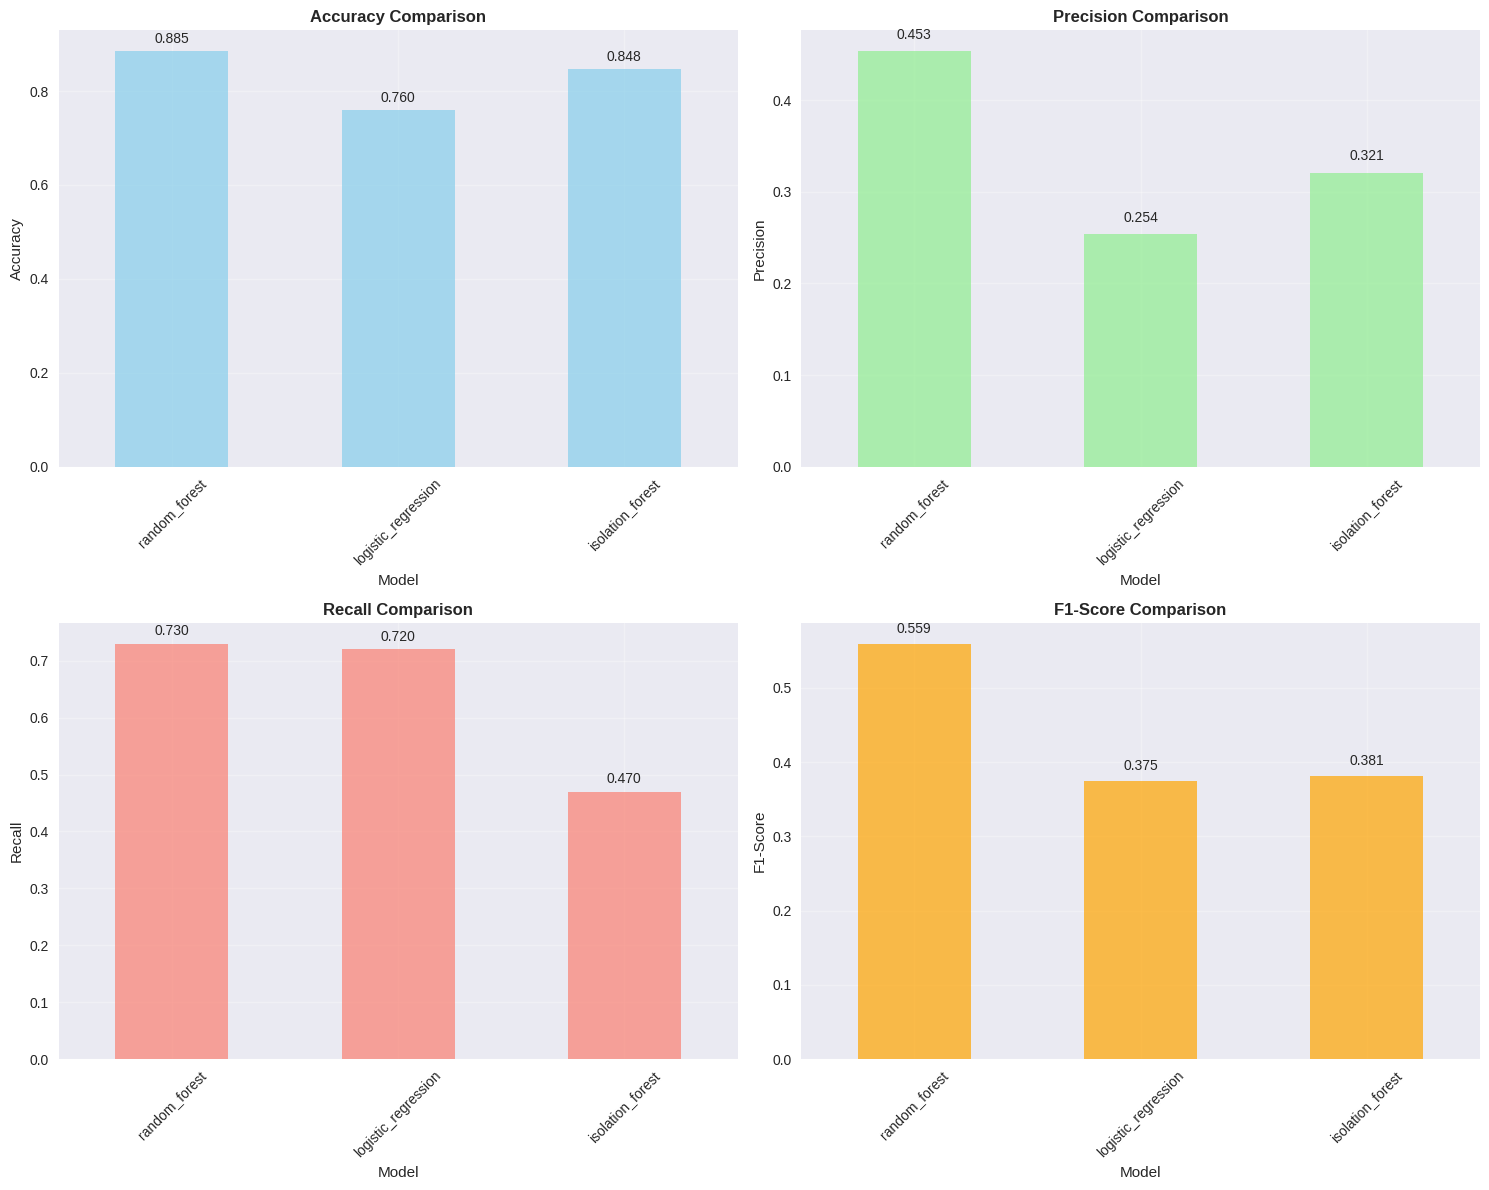

In [7]:
# Create comparison dataframe
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df[['accuracy', 'precision', 'recall', 'f1_score']]
comparison_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

print("Model Comparison:")
print("=" * 50)
print(comparison_df.round(4))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'salmon', 'orange']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    comparison_df[metric].plot(kind='bar', ax=ax, color=colors[i], alpha=0.7)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('Model')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for j, v in enumerate(comparison_df[metric]):
        ax.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 5. Detailed Model Analysis

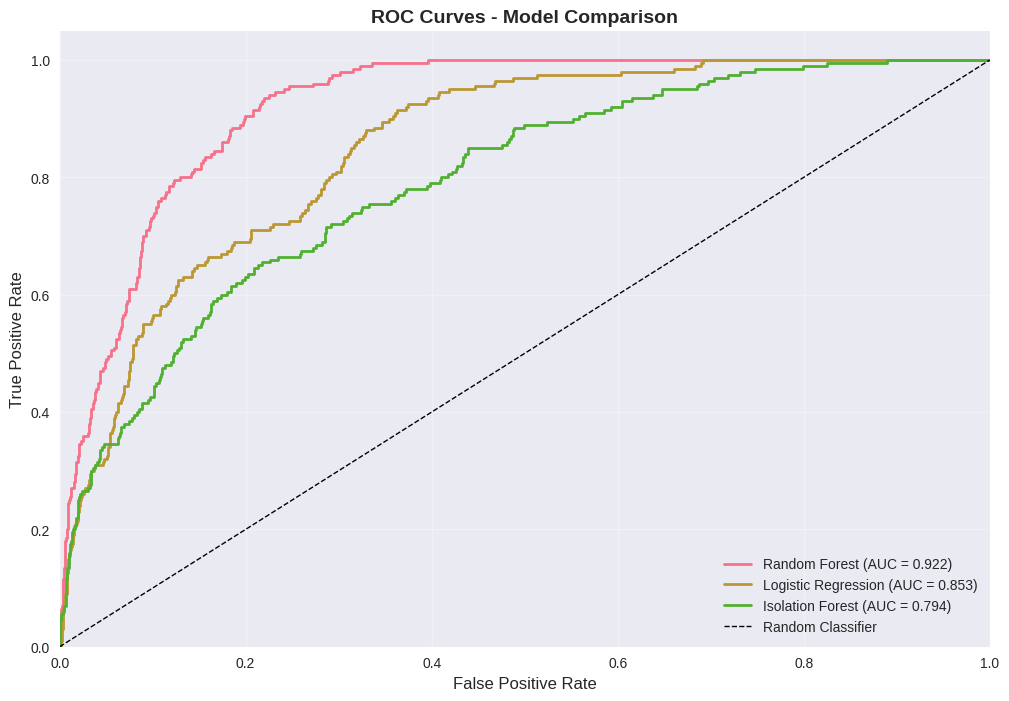

In [8]:
# ROC Curves
plt.figure(figsize=(12, 8))

for model_type, detector in trained_models.items():
    if model_type == 'isolation_forest':
        # For isolation forest, use decision function
        scores = detector.model.decision_function(X_test)
        scores_normalized = (scores - scores.min()) / (scores.max() - scores.min())
        y_prob = 1 - scores_normalized
    else:
        y_prob = detector.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    plt.plot(fpr, tpr, linewidth=2, 
             label=f'{model_type.replace("_", " ").title()} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

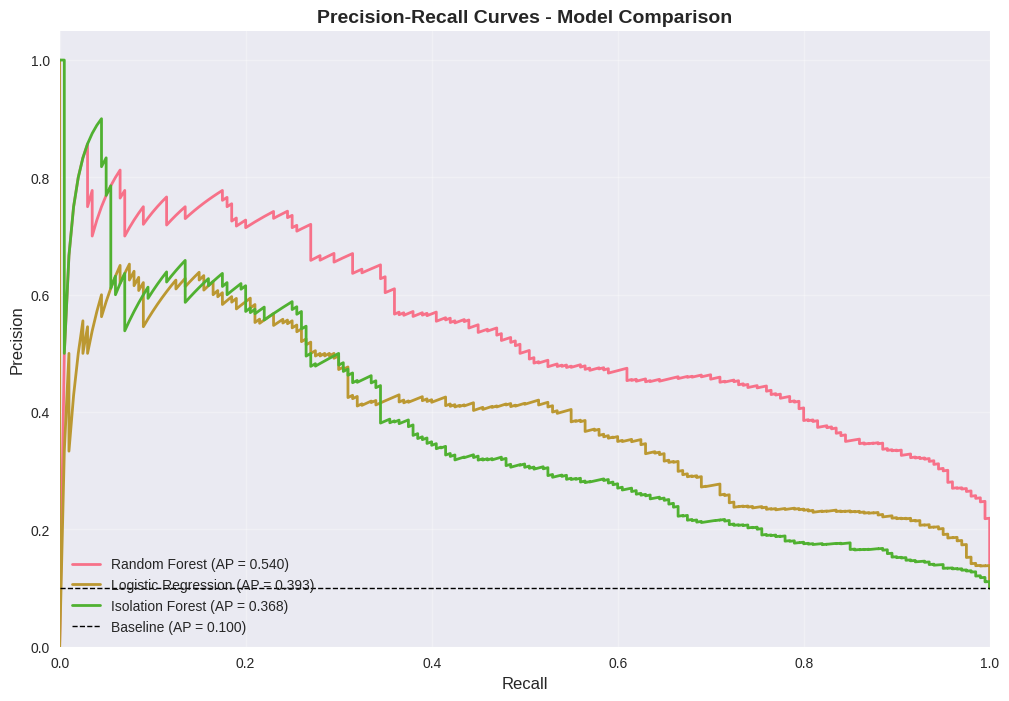

In [9]:
# Precision-Recall Curves
plt.figure(figsize=(12, 8))

for model_type, detector in trained_models.items():
    if model_type == 'isolation_forest':
        scores = detector.model.decision_function(X_test)
        scores_normalized = (scores - scores.min()) / (scores.max() - scores.min())
        y_prob = 1 - scores_normalized
    else:
        y_prob = detector.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    avg_precision = average_precision_score(y_test, y_prob)
    
    plt.plot(recall, precision, linewidth=2,
             label=f'{model_type.replace("_", " ").title()} (AP = {avg_precision:.3f})')

# Baseline
baseline_precision = y_test.mean()
plt.axhline(y=baseline_precision, color='k', linestyle='--', linewidth=1, 
            label=f'Baseline (AP = {baseline_precision:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Confusion Matrices

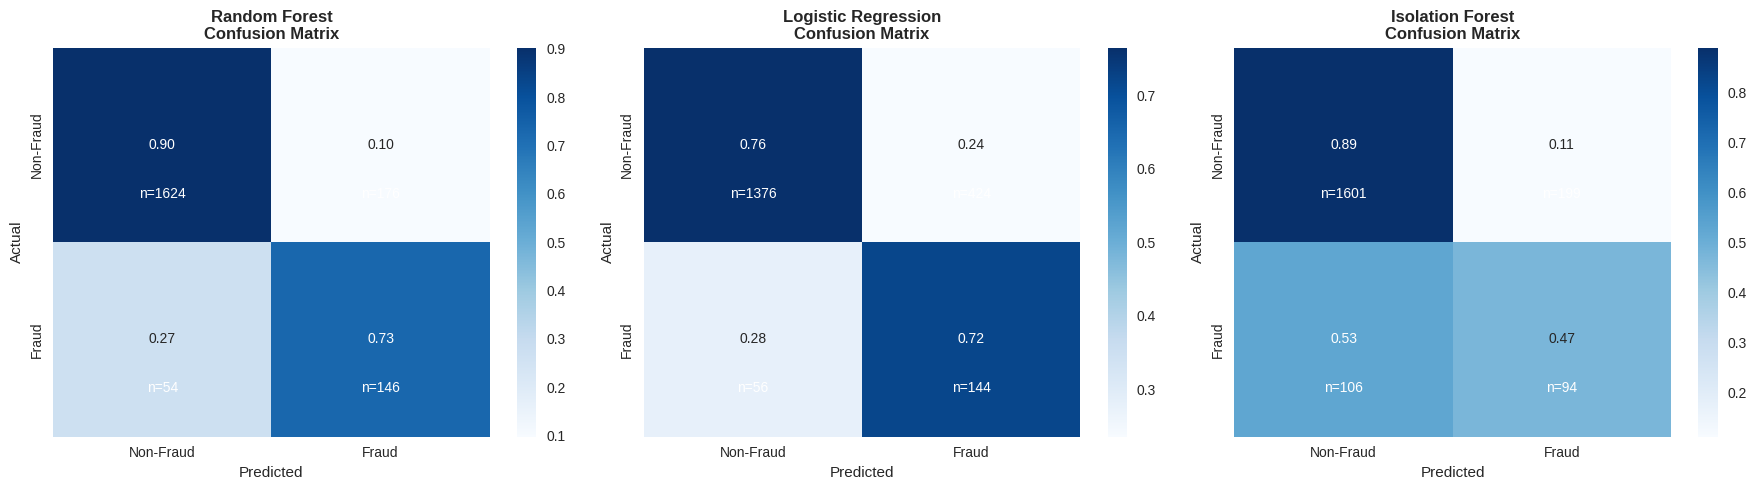

In [10]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (model_type, detector) in enumerate(trained_models.items()):
    y_pred = detector.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'],
                ax=axes[i])
    
    axes[i].set_title(f'{model_type.replace("_", " ").title()}\nConfusion Matrix', 
                      fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    
    # Add raw counts as text
    for j in range(2):
        for k in range(2):
            axes[i].text(k+0.5, j+0.75, f'n={cm[j,k]}', 
                        ha='center', va='center', fontsize=10, color='white')

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

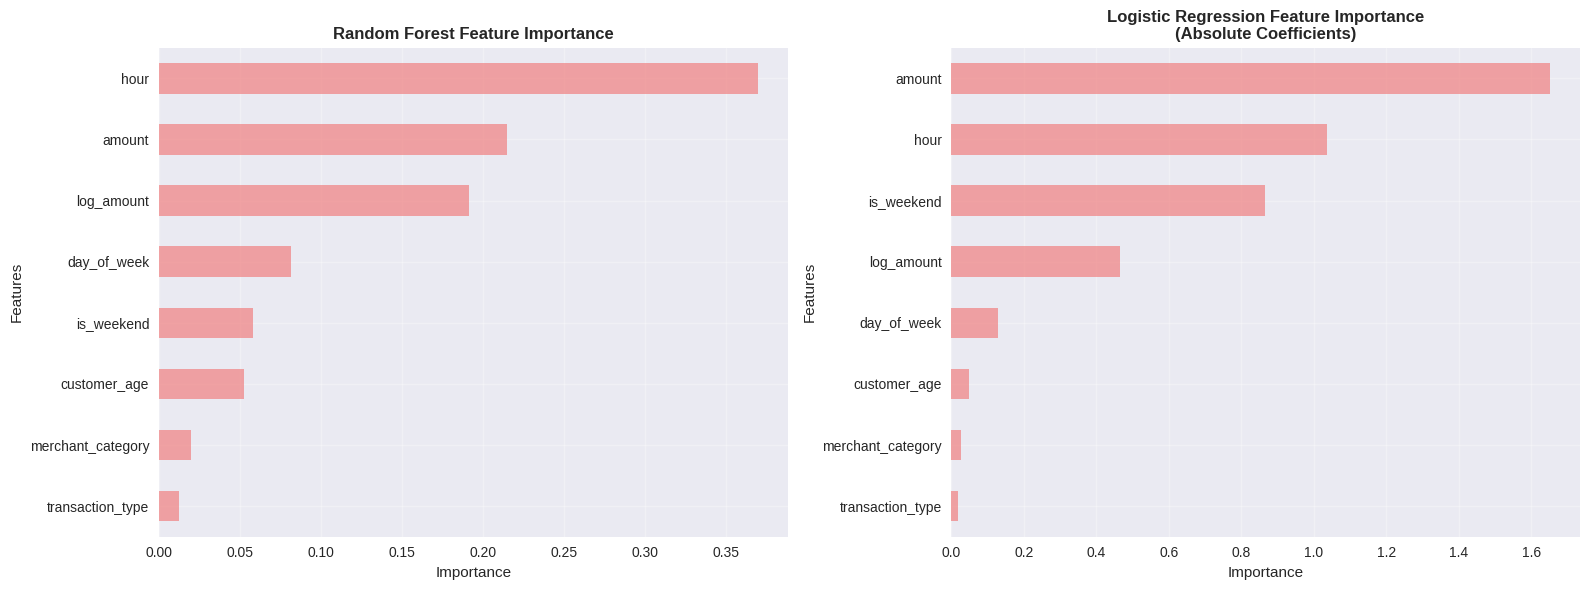


Top 5 Most Important Features:

Random Forest:
  hour: 0.3693
  amount: 0.2149
  log_amount: 0.1914
  day_of_week: 0.0818
  is_weekend: 0.0578

Logistic Regression:
  amount: 1.6521
  hour: 1.0376
  is_weekend: 0.8655
  log_amount: 0.4662
  day_of_week: 0.1275


In [11]:
# Feature importance for tree-based models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

feature_importance_models = ['random_forest', 'logistic_regression']

for i, model_type in enumerate(feature_importance_models):
    detector = trained_models[model_type]
    
    if model_type == 'random_forest':
        importances = detector.model.feature_importances_
        title = 'Random Forest Feature Importance'
    elif model_type == 'logistic_regression':
        importances = np.abs(detector.model.coef_[0])
        title = 'Logistic Regression Feature Importance\n(Absolute Coefficients)'
    
    # Create dataframe for better handling
    feature_importance_df = pd.DataFrame({
        'feature': data_processor.feature_columns,
        'importance': importances
    }).sort_values('importance', ascending=True)
    
    # Plot
    feature_importance_df.plot(x='feature', y='importance', kind='barh', 
                               ax=axes[i], color='lightcoral', alpha=0.7)
    axes[i].set_title(title, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Importance')
    axes[i].set_ylabel('Features')
    axes[i].legend().set_visible(False)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print top features
print("\nTop 5 Most Important Features:")
print("=" * 40)
for model_type in feature_importance_models:
    detector = trained_models[model_type]
    
    if model_type == 'random_forest':
        importances = detector.model.feature_importances_
    else:
        importances = np.abs(detector.model.coef_[0])
    
    feature_importance_df = pd.DataFrame({
        'feature': data_processor.feature_columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"\n{model_type.replace('_', ' ').title()}:")
    for _, row in feature_importance_df.head().iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

## 8. Cross-Validation Analysis

Performing 5-fold cross-validation...

Random Forest:
  CV F1-Scores: [0.5902439  0.57425743 0.55086849 0.5994695  0.59640103]
  Mean F1-Score: 0.5822 (+/- 0.0359)

Logistic Regression:
  CV F1-Scores: [0.36654804 0.39388795 0.37459283 0.37037037 0.38461538]
  Mean F1-Score: 0.3780 (+/- 0.0199)



/tmp/ipykernel_134965/2013173279.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(cv_data, labels=model_names, patch_artist=True)


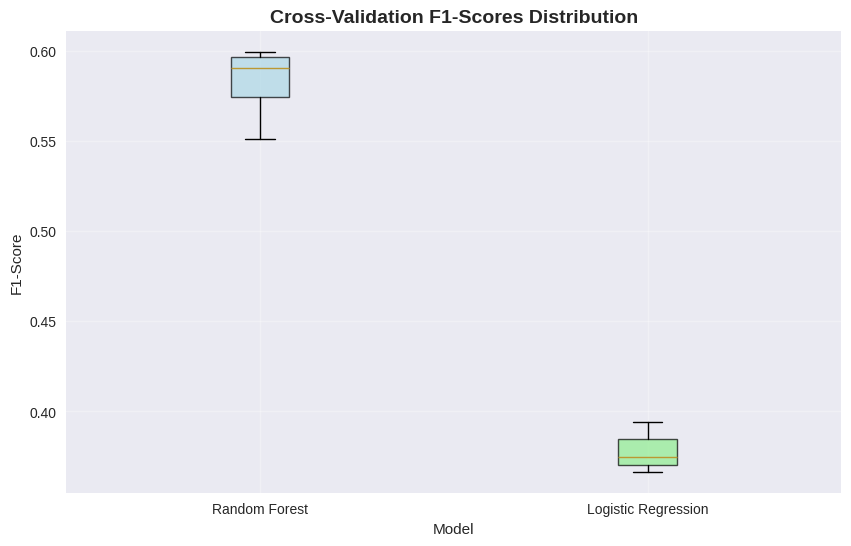

In [12]:
# Cross-validation for supervised models
cv_results = {}
cv_folds = 5
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"Performing {cv_folds}-fold cross-validation...\n")

supervised_models = ['random_forest', 'logistic_regression']

for model_type in supervised_models:
    detector = FraudDetector(model_type=model_type)
    
    # Cross-validation scores
    cv_scores = cross_val_score(detector.model, X_train, y_train, 
                                cv=cv, scoring='f1')
    
    cv_results[model_type] = cv_scores
    
    print(f"{model_type.replace('_', ' ').title()}:")
    print(f"  CV F1-Scores: {cv_scores}")
    print(f"  Mean F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print()

# Visualization
plt.figure(figsize=(10, 6))
cv_data = [cv_results[model] for model in supervised_models]
model_names = [model.replace('_', ' ').title() for model in supervised_models]

box_plot = plt.boxplot(cv_data, labels=model_names, patch_artist=True)

colors = ['lightblue', 'lightgreen']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Cross-Validation F1-Scores Distribution', fontsize=14, fontweight='bold')
plt.ylabel('F1-Score')
plt.xlabel('Model')
plt.grid(True, alpha=0.3)
plt.show()

## 9. Model Selection and Final Evaluation

In [13]:
# Select best model based on F1-score
best_model_name = max(model_results.keys(), 
                      key=lambda x: model_results[x]['f1_score'])
best_model = trained_models[best_model_name]
best_results = model_results[best_model_name]

print("BEST MODEL SELECTION")
print("=" * 50)
print(f"Selected Model: {best_model_name.replace('_', ' ').title()}")
print(f"Selection Criteria: Highest F1-Score")

print(f"\nBest Model Performance:")
print(f"  Accuracy: {best_results['accuracy']:.4f}")
print(f"  Precision: {best_results['precision']:.4f}")
print(f"  Recall: {best_results['recall']:.4f}")
print(f"  F1-Score: {best_results['f1_score']:.4f}")
if 'auc_score' in best_results:
    print(f"  AUC-ROC: {best_results['auc_score']:.4f}")

# Detailed classification report
y_pred_best = best_model.predict(X_test)
print(f"\nDetailed Classification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred_best, target_names=['Non-Fraud', 'Fraud']))

BEST MODEL SELECTION
Selected Model: Random Forest
Selection Criteria: Highest F1-Score

Best Model Performance:
  Accuracy: 0.8850
  Precision: 0.4534
  Recall: 0.7300
  F1-Score: 0.5594
  AUC-ROC: 0.9222

Detailed Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.97      0.90      0.93      1800
       Fraud       0.45      0.73      0.56       200

    accuracy                           0.89      2000
   macro avg       0.71      0.82      0.75      2000
weighted avg       0.92      0.89      0.90      2000



In [14]:
# Save the best model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"../models/trained/best_fraud_detector_{best_model_name}_{timestamp}.pkl"

os.makedirs('../models/trained', exist_ok=True)
best_model.save_model(model_filename)

# Save results
results_filename = f"../models/trained/model_evaluation_results_{timestamp}.json"

import json
with open(results_filename, 'w') as f:
    json.dump({
        'best_model': best_model_name,
        'best_model_results': best_results,
        'all_model_results': model_results,
        'training_info': {
            'train_size': len(X_train),
            'test_size': len(X_test),
            'features': data_processor.feature_columns,
            'timestamp': timestamp
        }
    }, f, indent=2)

print(f"\nMODEL AND RESULTS SAVED")
print("=" * 50)
print(f"Best model saved to: {model_filename}")
print(f"Evaluation results saved to: {results_filename}")

INFO:models.fraud_detector:Model saved to ../models/trained/best_fraud_detector_random_forest_20250904_100309.pkl



MODEL AND RESULTS SAVED
Best model saved to: ../models/trained/best_fraud_detector_random_forest_20250904_100309.pkl
Evaluation results saved to: ../models/trained/model_evaluation_results_20250904_100309.json


## 10. Summary and Recommendations

In [15]:
# Final summary
print("MODEL TRAINING AND EVALUATION SUMMARY")
print("=" * 50)

print(f"\n1. DATA OVERVIEW:")
print(f"   • Total samples: {len(df)}")
print(f"   • Training samples: {len(X_train)}")
print(f"   • Test samples: {len(X_test)}")
print(f"   • Features used: {len(data_processor.feature_columns)}")
print(f"   • Fraud rate: {y.mean()*100:.2f}%")

print(f"\n2. MODELS EVALUATED:")
for model_type, results in model_results.items():
    print(f"   • {model_type.replace('_', ' ').title()}: F1={results['f1_score']:.4f}")

print(f"\n3. BEST MODEL:")
print(f"   • Model: {best_model_name.replace('_', ' ').title()}")
print(f"   • F1-Score: {best_results['f1_score']:.4f}")
print(f"   • Precision: {best_results['precision']:.4f}")
print(f"   • Recall: {best_results['recall']:.4f}")

print(f"\n4. BUSINESS IMPACT:")
# Calculate business metrics
total_fraud_cases = y_test.sum()
detected_fraud_cases = confusion_matrix(y_test, y_pred_best)[1, 1]
false_positives = confusion_matrix(y_test, y_pred_best)[0, 1]

print(f"   • Total fraud cases in test set: {total_fraud_cases}")
print(f"   • Detected fraud cases: {detected_fraud_cases} ({detected_fraud_cases/total_fraud_cases*100:.1f}%)")
print(f"   • False positives: {false_positives} ({false_positives/len(y_test)*100:.1f}% of all transactions)")

print(f"\n5. RECOMMENDATIONS:")
print(f"   • Deploy {best_model_name.replace('_', ' ').title()} as production model")
print(f"   • Monitor model performance with emphasis on recall (fraud detection rate)")
print(f"   • Consider threshold tuning based on business cost of false positives vs false negatives")
print(f"   • Implement regular model retraining with new data")
print(f"   • Set up alerting for model performance degradation")

print(f"\n" + "=" * 50)
print(f"MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print(f"Ready for production deployment.")

MODEL TRAINING AND EVALUATION SUMMARY

1. DATA OVERVIEW:
   • Total samples: 10000
   • Training samples: 8000
   • Test samples: 2000
   • Features used: 8
   • Fraud rate: 10.00%

2. MODELS EVALUATED:
   • Random Forest: F1=0.5594
   • Logistic Regression: F1=0.3750
   • Isolation Forest: F1=0.3813

3. BEST MODEL:
   • Model: Random Forest
   • F1-Score: 0.5594
   • Precision: 0.4534
   • Recall: 0.7300

4. BUSINESS IMPACT:
   • Total fraud cases in test set: 200
   • Detected fraud cases: 146 (73.0%)
   • False positives: 176 (8.8% of all transactions)

5. RECOMMENDATIONS:
   • Deploy Random Forest as production model
   • Monitor model performance with emphasis on recall (fraud detection rate)
   • Consider threshold tuning based on business cost of false positives vs false negatives
   • Implement regular model retraining with new data
   • Set up alerting for model performance degradation

MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!
Ready for production deployment.
